# Laboratorio 3 BI

### Integrantes:
### Luisa Fernanda Fuentes Ladino - 202014321
### Andrés Felipe Lugo Saavedra - 202012538

In [1]:
seed = 161
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Composicion de pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

# Regresion lineal
from sklearn.linear_model import LinearRegression

# Importar/ Exportar modelos
from joblib import dump, load

# Metricas
from sklearn.metrics import mean_squared_error as mse

# q-q plots
import scipy.stats as stats

# Carga de datos

In [2]:
# Se cargan los datos. 
df_original = pd.read_csv('202220_Laboratorio_3_data_university_admission_train.csv')
df_train = df_original.copy()
print(df_train.shape)
df_train.head(5)

(1569, 10)


,Unnamed: 0,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Admission Points
0,0,479,327,113,4,4.00,2.77,8.88,1,84.47
1,1,446,301,92,1,1.85,1.50,7.71,0,45.08
2,2,336,297,100,1,2.41,1.59,7.89,0,47.42
3,3,20,303,98,3,3.50,3.00,8.50,0,62.00
4,4,432,320,94,2,1.38,3.50,8.78,1,73.00


In [3]:
df_test = pd.read_csv('202220_Laboratorio_3_data_university_admission_test.csv')
print(df_test.shape)
df_test.head(5)

(175, 8)


,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,117,299,102,3,4.0,3.5,8.62,0
1,49,321,110,3,3.5,5.0,8.85,1
2,94,301,97,2,3.0,3.0,7.88,1
3,108,338,117,4,3.5,4.5,9.46,1
4,327,299,100,3,2.0,2.0,8.02,0


# Entendimiento y perfilamiento de datos

In [4]:
df_train.dtypes

Unnamed: 0             int64
Serial No.             int64
GRE Score              int64
TOEFL Score            int64
University Rating      int64
SOP                  float64
LOR                  float64
CGPA                 float64
Research               int64
Admission Points     float64
dtype: object

In [5]:
df_test.dtypes

Serial No.             int64
GRE Score              int64
TOEFL Score            int64
University Rating      int64
SOP                  float64
LOR                  float64
CGPA                 float64
Research               int64
dtype: object

Saber si hay valores nuelos en las columnas

In [6]:
df_train.isnull().sum()

Unnamed: 0            0
Serial No.            0
GRE Score             0
TOEFL Score           0
University Rating     0
SOP                   0
LOR                   0
CGPA                  0
Research              0
Admission Points     65
dtype: int64

In [7]:
df_test.isnull().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
dtype: int64

## Limpieza de datos, se eliminarán los valores nulos, los duplicados y las columnas que no aportan información valiosa a la regresión (Serial No y Unnamed)

In [8]:
df_train_l=df_train.copy()

df_train_l = df_train_l.dropna()
df_train_l = df_train_l.drop_duplicates()

df_train_l = df_train_l.drop(['Unnamed: 0', 'Serial No.'], axis=1)

df_train_l.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Admission Points
0,327,113,4,4.00,2.77,8.88,1,84.47
1,301,92,1,1.85,1.50,7.71,0,45.08
2,297,100,1,2.41,1.59,7.89,0,47.42
3,303,98,3,3.50,3.00,8.50,0,62.00
4,320,94,2,1.38,3.50,8.78,1,73.00


In [9]:
df_train_l.isnull().sum()

GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Admission Points     0
dtype: int64

#### Búsqueda de relaciones entre variables (diagramas de dispersión), todo esto con nuestra variable objetivo (Admission Points)

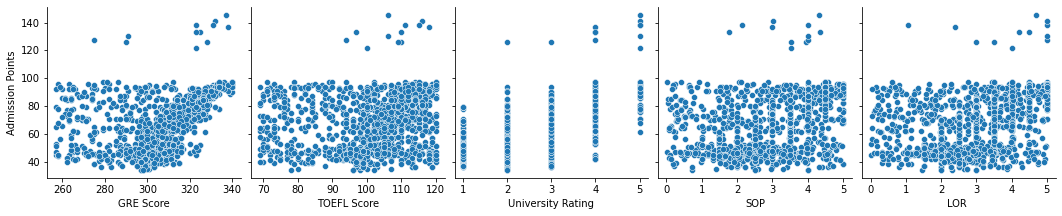

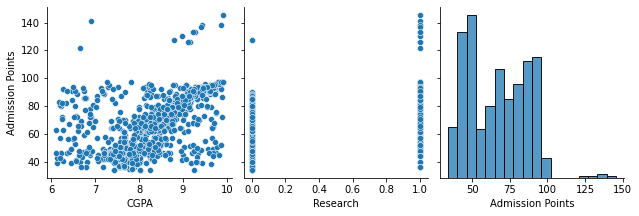

In [10]:
sns.pairplot(df_train_l, height=3, y_vars = 'Admission Points', x_vars = df_train_l.columns[0:5], kind='scatter')
sns.pairplot(df_train_l, height=3, y_vars = 'Admission Points', x_vars = df_train_l.columns[5:], kind='scatter')

Podemos observar que unos buenos candidatos muy relacionados con la varibale objetivo son:
1. CGPA
2. GRE Score

#### Búsqueda de relaciones entre variables (Matriz de correlaciones)

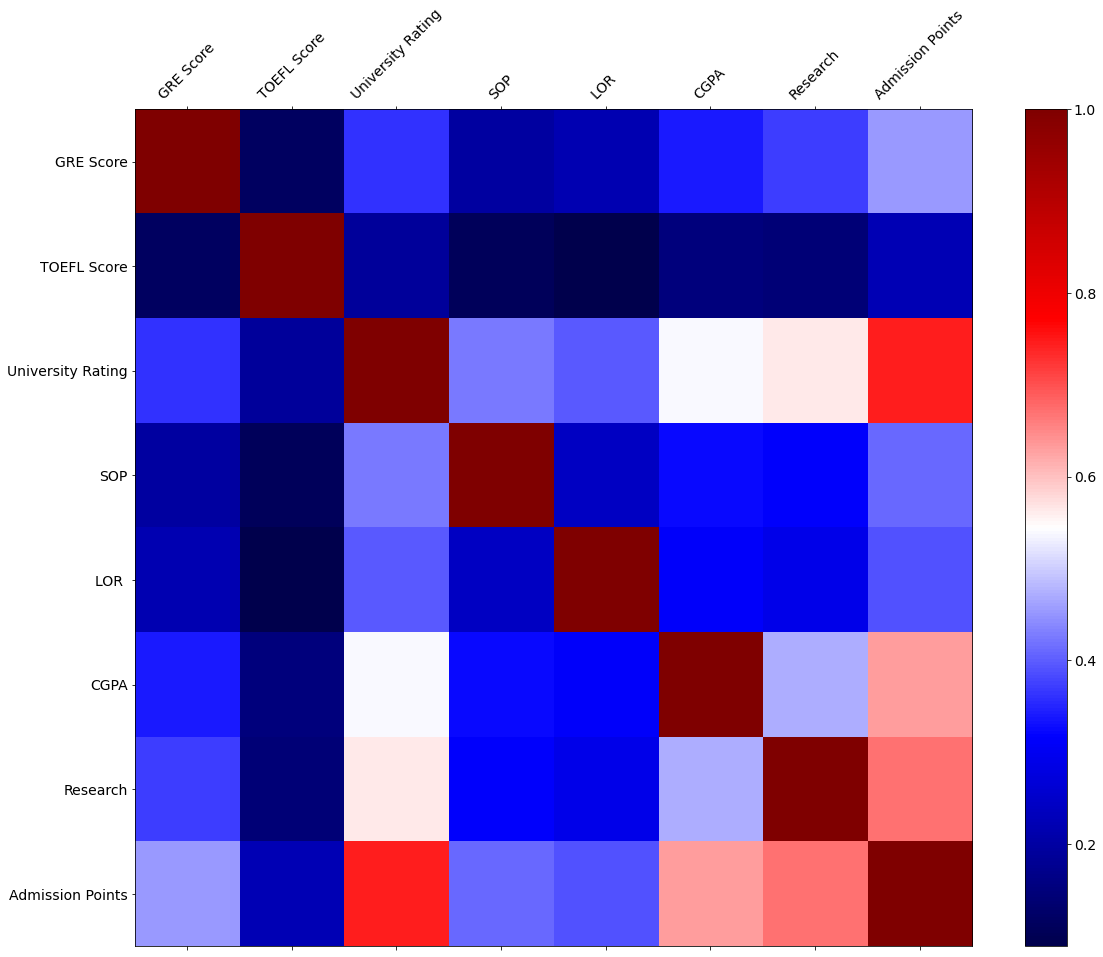

In [11]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df_train_l.corr(), fignum=f.number, cmap = 'seismic')
plt.xticks(range(df_train_l.select_dtypes(['number']).shape[1]), df_train_l.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_train_l.select_dtypes(['number']).shape[1]), df_train_l.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
_ = cb.ax.tick_params(labelsize=14)

Podemos observar que unos buenos candidatos muy relacionados con la varibale objetivo son:
1. CGPA
2. University Rating
3. Research

# Implementación de la Regresión Lineal

In [12]:
# Se usa un transformador para seleccionar unicamente las columnas que se quieren usar
selected_cols = ['CGPA','University Rating','Research']

pre = [('initial',ColumnTransformer([("selector", 'passthrough',selected_cols)])),]

In [13]:
# Creación del modelo
model = [('model', LinearRegression())]

In [14]:
# Decalra el pipeline
pipeline = Pipeline(pre+model)

In [15]:
# Extraemos las variables explicativas y objetivo para entrenar
X = df_train_l.drop('Admission Points', axis = 1)
y = df_train_l['Admission Points']

pipeline = pipeline.fit(X,y)

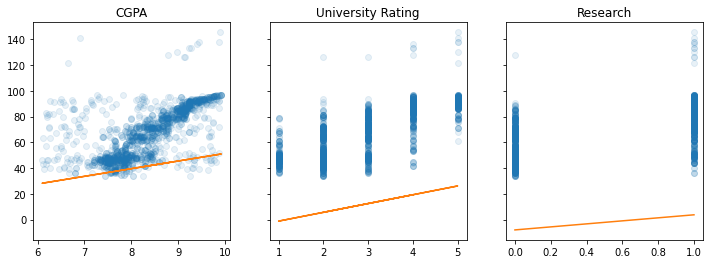

In [16]:
# Visualizamos la regresion lineal en cada dimension
f, axs = plt.subplots(1, len(selected_cols), sharey=True, figsize = (12,4))

for i in range(len(selected_cols)):

    pos_col = i
    col = selected_cols[pos_col]

    # Variable x
    x = X[col]
    # Pendiente
    m = pipeline['model'].coef_[pos_col]
    # Interceto
    b = pipeline['model'].intercept_

    axs[i].plot(x, y, 'o', alpha = 0.1)
    axs[i].plot(x, x*m + b)
    axs[i].set_title(col)

# Exportar e Importar el Modelo

In [17]:
# Usamos la lbreria joblib
filename = 'modelo.joblib'
# Se guarda
dump(pipeline, filename) 
# Se lee
p2 = load(filename)
p2

Pipeline(steps=[('initial',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['CGPA', 'University Rating',
                                                   'Research'])])),
                ('model', LinearRegression())])

In [18]:
df_test_c=df_test.copy()
df_test_c.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,117,299,102,3,4.0,3.5,8.62,0
1,49,321,110,3,3.5,5.0,8.85,1
2,94,301,97,2,3.0,3.0,7.88,1
3,108,338,117,4,3.5,4.5,9.46,1
4,327,299,100,3,2.0,2.0,8.02,0


In [19]:
# Clasificamos los datos de test
df_test_c['Admission Points'] = p2.predict(df_test_c)

<AxesSubplot:xlabel='Admission Points', ylabel='Count'>

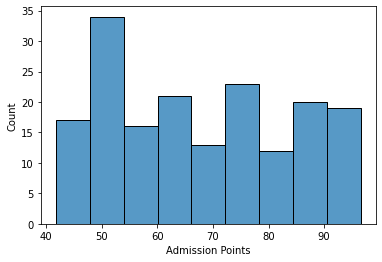

In [20]:
sns.histplot(df_test_c['Admission Points'])

In [21]:
df_test_c.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Admission Points
0,117,299,102,3,4.0,3.5,8.62,0,63.723027
1,49,321,110,3,3.5,5.0,8.85,1,76.826433
2,94,301,97,2,3.0,3.0,7.88,1,64.233983
3,108,338,117,4,3.5,4.5,9.46,1,87.278908
4,327,299,100,3,2.0,2.0,8.02,0,60.156403


# Coeficientes

In [22]:
pipeline['model'].coef_

array([ 5.94437346,  6.82640742, 11.73619957])

In [23]:
# En DataFrame
pd.DataFrame({'columns':selected_cols, 'coef':pipeline['model'].coef_})

,columns,coef
0,CGPA,5.944373
1,University Rating,6.826407
2,Research,11.736200


# Normalizados

In [24]:
#Normalización de train
scaler = MinMaxScaler()
transformed_train= scaler.fit_transform(df_train_l)

transformed_train = pd.DataFrame(transformed_train)
#transformed_data["Admission Points"] = df_train_l["Admission Points"]
transformed_train.columns = df_train_l.columns

In [25]:
transformed_train.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Admission Points
0,0.843373,0.862745,0.75,0.799197,0.554,0.727749,1.0,0.452646
1,0.530120,0.450980,0.00,0.367470,0.300,0.421466,0.0,0.099372
2,0.481928,0.607843,0.00,0.479920,0.318,0.468586,0.0,0.120359
3,0.554217,0.568627,0.50,0.698795,0.600,0.628272,0.0,0.251121
4,0.759036,0.490196,0.25,0.273092,0.700,0.701571,1.0,0.349776


In [26]:
df_test_2=df_test.copy()
df_test_2.head()

scaler = MinMaxScaler()
transformed_test= scaler.fit_transform(df_test_2)

transformed_test = pd.DataFrame(transformed_test)
#transformed_data["Admission Points"] = df_train_l["Admission Points"]
transformed_test.columns = df_test_2.columns

# Regresión lineal con archivos normalizados

In [27]:
# Se usa un transformador para seleccionar unicamente las columnas que se quieren usar
selected_cols_s = ['CGPA','University Rating','Research']

pre2 = [('initial',ColumnTransformer([("selector", 'passthrough',selected_cols_s)])),]

In [28]:
# Creación del modelo
model2 = [('model', LinearRegression())]

In [29]:
# Decalra el pipeline
pipeline2 = Pipeline(pre2+model2)

In [30]:
# Extraemos las variables explicativas y objetivo para entrenar
X2 = transformed_train.drop('Admission Points', axis = 1)
y2 = transformed_train['Admission Points']

pipeline2 = pipeline2.fit(X2,y2)

# Coeficientes

In [31]:
# Vuelve a imprimir los coeficientes
pd.DataFrame({'columns':selected_cols_s, 'coef':pipeline2['model'].coef_})

,columns,coef
0,CGPA,0.203655
1,University Rating,0.244894
2,Research,0.105257


# Exportación joblib

In [32]:
# Usamos la libreria joblib
filename2 = 'modelo.joblib'
# Se guarda
dump(pipeline2, filename2) 
# Se lee
p3 = load(filename2)
p3

Pipeline(steps=[('initial',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['CGPA', 'University Rating',
                                                   'Research'])])),
                ('model', LinearRegression())])

# Clasificación con datos de test

In [33]:
# Clasificamos los datos de test
transformed_test['Admission Points'] = p3.predict(transformed_test)

In [34]:
transformed_test.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Admission Points
0,0.224696,0.183673,0.346154,0.50,0.750,0.625,0.592834,0.0,0.252960
1,0.087045,0.632653,0.653846,0.50,0.625,1.000,0.667752,1.0,0.373474
2,0.178138,0.224490,0.153846,0.25,0.500,0.500,0.351792,1.0,0.247904
3,0.206478,0.979592,0.923077,0.75,0.625,0.875,0.866450,1.0,0.475163
4,0.649798,0.183673,0.269231,0.50,0.250,0.250,0.397394,0.0,0.213157


<AxesSubplot:xlabel='Admission Points', ylabel='Count'>

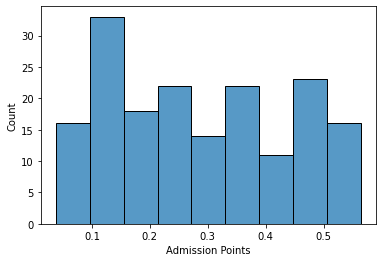

In [35]:
sns.histplot(transformed_test['Admission Points'])

# Métricas de un Modelo

In [36]:
#Coeficiente de Determinación 𝑅2
p3.score(X2,y2)

0.690088535136133

In [37]:
#Root-Mean-Square Error (RMSE)

y_true = y2
y_predicted = p3.predict(X2)

# Note que hay que sacarle la raiz al valor
np.sqrt(mse(y_true, y_predicted))

0.09609451519807208

# Supuestos de la Regresión Lineal

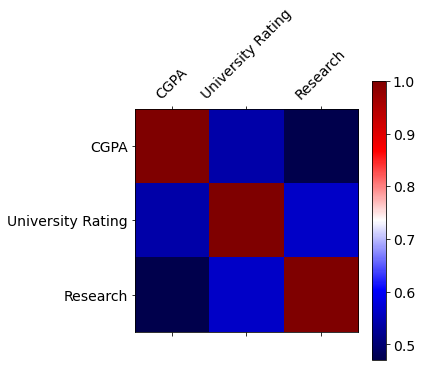

In [38]:
#Colinealidad
df_temp = transformed_train[selected_cols_s]


f = plt.figure(figsize=(5, 5))
plt.matshow(df_temp.corr(), fignum=f.number, cmap = 'seismic')
plt.xticks(range(df_temp.select_dtypes(['number']).shape[1]), df_temp.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_temp.select_dtypes(['number']).shape[1]), df_temp.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
_ = cb.ax.tick_params(labelsize=14)

Se puede observar que no existe una alta colinealidad entre las columnas seleccionadas para implementar el algoritmo de regresión lineal (CGPA, University Rating, Research)

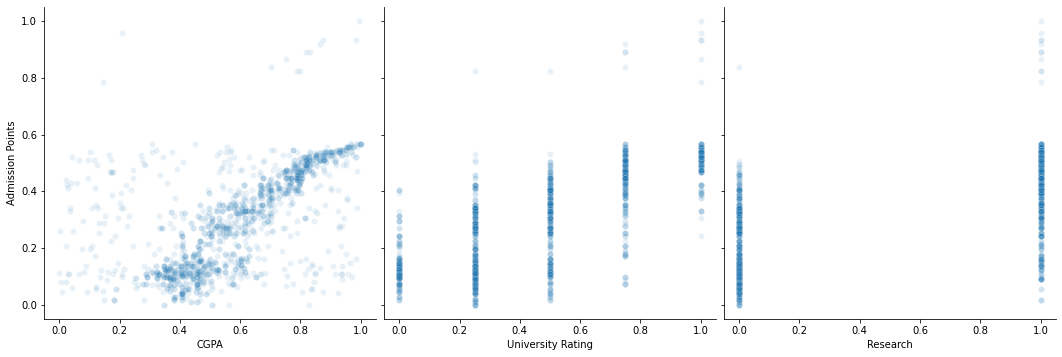

In [39]:
#Linealidad
sns.pairplot(transformed_train, height=5, aspect = 1, y_vars = 'Admission Points', x_vars = ['CGPA','University Rating','Research'], kind='scatter', plot_kws = {'alpha':0.1})

# Normalidad en los Errores

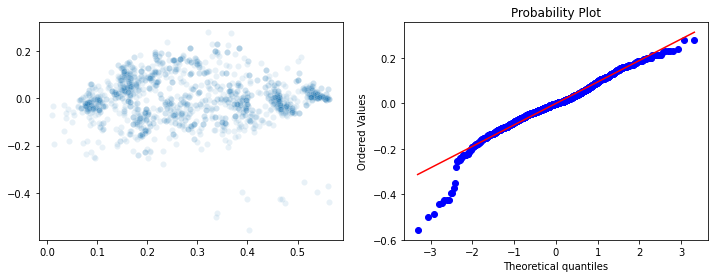

In [40]:
X = transformed_train.drop('Admission Points', axis = 1)
y = transformed_train['Admission Points']

# Calculamos los errores
errors = (p3.predict(X) - y).values

fig, axes = plt.subplots(1, 2, figsize = (12,4))

# Dispersión
sns.scatterplot(x = p3.predict(X), y = errors, alpha = 0.1, ax = axes[0])

# q-q plot
_ = stats.probplot(errors, dist="norm", plot=axes[1])

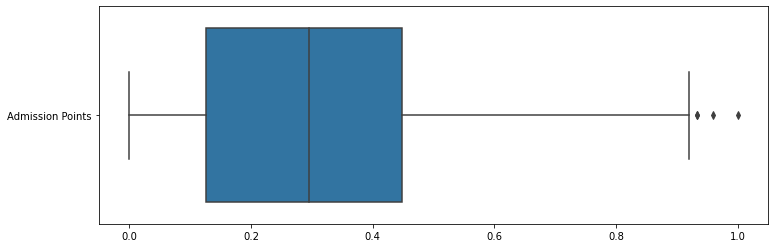

In [41]:
# Diagrama de caja
fig=plt.figure(figsize=(12,4))
ax = sns.boxplot(data= transformed_train[['Admission Points']], orient="h")

# Varianza Constante (Homocedasticidad)

<AxesSubplot:xlabel='Admission Points'>

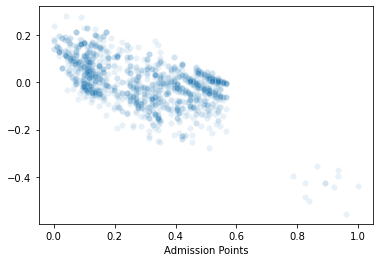

In [42]:
# Visualizamos nuestros datos
sns.scatterplot(data  = transformed_train, x = 'Admission Points', y = errors, alpha = 0.1)